# Import

In [1]:
from qDrift.hamsimqDrift import AlgorithmHamSimqDrift
from pytket.circuit import Circuit
from openfermion.utils.operator_utils import count_qubits

from utils.func import *
from utils.term_grouping import *
from utils.min_clique import *
from utils.hamlib import *
from utils.evol_real import *
from utils.plot import *
from utils.driver import *
from utils.JW import *

from Pauli_Gadgets.paulis import *

import numpy as np
import matplotlib.pyplot as plt

def gen_sys_param(n=10, sample_steps=100000, N=1):
    global t_max
    global initial_state_circ
    global n_qdrift_steps
    global sample_space
    global seg
    global t_list

    t_max=2
    t_list = [0.5,1,2,5]
    seg = N
    initial_state_circ = Circuit(n)
    for i in range(n):
        initial_state_circ.H(i)
    n_qdrift_steps = sample_steps
    sample_space = np.arange(0,sample_steps+1,1)

# Hydrogen chain

In [2]:
driver = PySCFDriver_custom()
bond_length = 1.0
n_sites = 3
driver.load_molecule(
    atom=[('H', (0, 0, i * bond_length)) for i in range(n_sites)], # Create a molecular data object for the hydrogen chain
    basis="sto-3g",          # Basis set for quantum chemistry calculation
    multiplicity=1,          # Spin multiplicity for molecule, since the total spin of H2O is S=0，its spin multiplicity is 2S+1=1
    charge=0,                 # Total charge of molecule, since H2O is charge neutral, its charge=0
    unit="Angstrom"
)
driver.run_scf()             # Perform Hartree Fock calculation

# np.set_printoptions(precision=4, linewidth=150)

hpq = driver.get_onebody_tensor("int1e_kin") + driver.get_onebody_tensor("int1e_nuc")
vpqrs = driver.get_twobody_tensor()
# assert np.shape(hpq)==(7, 7)             # H2O has 7 orbitals when using STO-3G basis.
# assert np.shape(vpqrs)==(7, 7, 7, 7)

# print(hpq)
operator = get_molecular_hamiltonian(hpq,vpqrs,driver)
n_qubits = count_qubits(operator)
number, coulomb, hopping, no_excitation, double_excitation = JW_transformation(operator)
numbers, coulombs, hoppings, no_excitations, double_excitations = JW_transformation(operator,True)

number_op, number_co = convert_op_to_input(number,n_qubits)
hopping_op, hopping_co = convert_op_to_input(hopping,n_qubits)
coulomb_op, coulomb_co = convert_op_to_input(coulomb,n_qubits)
no_excitation_op, no_excitation_co = convert_op_to_input(no_excitation,n_qubits)
double_excitation_op, double_excitation_co = convert_op_to_input(double_excitation,n_qubits)

numbers_op, numbers_co = convert_op_to_input(numbers,n_qubits,True)
hoppings_op, hoppings_co = convert_twobody_op_to_input(hoppings,n_qubits,True)
coulombs_op, coulombs_co = convert_op_to_input(list(coulombs),n_qubits,True)
no_excitations_op, no_excitations_co = convert_twobody_op_to_input(list(no_excitations),n_qubits,True)
double_excitations_op, double_excitations_co = convert_twobody_op_to_input(list(double_excitations),n_qubits,True)

# max_part_group = [[number_op[0], number_op[-2],hopping_op[0], hopping_op[1]],number_op[2:4],[number_op[1], number_op[-1], hopping_op[-2],hopping_op[-1]]]+coulombs_op+no_excitations_op+double_excitations_op
# max_coeff = [[(number_co[0]+number_co[-2]+abs(hopping_co[0])*2)/4],[number_co[2]],[(number_co[0]+number_co[-2]+abs(hopping_co[0])*2)/4]]+coulombs_co+no_excitations_co+double_excitations_co
max_part_group, max_coeff = site_excitation_group(numbers_op,hoppings_op,numbers_co,hoppings_co)

H_matrix = get_Hmatrix(number_op+hopping_op+coulomb_op+no_excitation_op+double_excitation_op,n_qubits,number_co+hopping_co+coulomb_co+no_excitation_co+double_excitation_co)

converged SCF energy = -1.52399620024611


In [3]:
U2p_overall = []
for i in range(3):
    gen_sys_param(n=n_qubits,sample_steps=10)
    drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,number_op+hopping_op+coulomb_op+no_excitation_op+double_excitation_op,number_co+hopping_co+coulomb_co+no_excitation_co+double_excitation_co,t_max,n_qdrift_steps,seg,noise=True)
    U2p,secdepth = drift_time_evolution.trotter(order=2, protected=True)
    U2p_overall.append(U2p)

In [ ]:
Ut_overall = []
for i in range(3):
    gen_sys_param(n=n_qubits,sample_steps=20)
    drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,number_op+hopping_op+coulomb_op+no_excitation_op+double_excitation_op,number_co+hopping_co+coulomb_co+no_excitation_co+double_excitation_co,t_max,n_qdrift_steps,seg,noise=True)
    Ut,ldepth = drift_time_evolution.trotter()
    Ut_overall.append(Ut)

In [ ]:
U2_overall = []
for i in range(3):
    gen_sys_param(n=n_qubits,sample_steps=10)
    drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,number_op+hopping_op+coulomb_op+no_excitation_op+double_excitation_op,number_co+hopping_co+coulomb_co+no_excitation_co+double_excitation_co,t_max,n_qdrift_steps,seg,noise=True)
    U2,secdepth = drift_time_evolution.trotter(order=2)
    U2_overall.append(U2)

In [ ]:
Urp_overall = []
for i in range(3): 
    gen_sys_param(n=n_qubits,sample_steps=20)
    drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,number_op+hopping_op+coulomb_op+no_excitation_op+double_excitation_op,number_co+hopping_co+coulomb_co+no_excitation_co+double_excitation_co,t_max,n_qdrift_steps,seg,noise=True)
    Urp,rpdepth = drift_time_evolution.trotter(rand=True)
    Urp_overall.append(Urp)

In [ ]:
gen_sys_param(n=n_qubits,sample_steps=secdepth[-1])
drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,max_part_group,max_coeff,t_max,n_qdrift_steps,seg,M=3,noise=True)
Um,sm,mdepth = drift_time_evolution.Drift_exp(depth=secdepth[-1])
Um_overall = []
Um_overall.append(Um)
for i in range(2):
    gen_sys_param(n=n_qubits,sample_steps=secdepth[-1])
    drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,max_part_group,max_coeff,t_max,n_qdrift_steps,seg,M=3,noise=True)
    Um,_,_ = drift_time_evolution.Drift_exp(sampled=sm,depth=secdepth[-1]) 
    Um_overall.append(Um)

In [ ]:
gen_sys_param(n=n_qubits)
drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,[number_op,hopping_op,coulomb_op,no_excitation_op,double_excitation_op],[number_co,hopping_co,coulomb_co,no_excitation_co,double_excitation_co],t_max,n_qdrift_steps,seg,M=3,noise=True)
Ug,sg,gdepth = drift_time_evolution.Drift_exp(depth=secdepth[-1],abs_coeff=True)
Ug_overall = []
Ug_overall.append(Ug)
for i in range(2):
    gen_sys_param(n=n_qubits,sample_steps=secdepth[-1])
    drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,[number_op,hopping_op,coulomb_op,no_excitation_op,double_excitation_op],[number_co,hopping_co,coulomb_co,no_excitation_co,double_excitation_co],t_max,n_qdrift_steps,seg,M=3,noise=True)
    Ug,_,_ = drift_time_evolution.Drift_exp(sampled=sg,depth=secdepth[-1]) 
    Ug_overall.append(Ug)

In [ ]:
gen_sys_param(n=n_qubits,sample_steps=secdepth[-1])
drift_time_evolution_parity = AlgorithmHamSimqDrift(initial_state_circ,[[h] for h in number_op+hopping_op+coulomb_op+no_excitation_op+double_excitation_op],[[c] for c in number_co+hopping_co+coulomb_co+no_excitation_co+double_excitation_co],t_max,n_qdrift_steps,seg,M=3,noise=True)
Uq,sq,qdepth = drift_time_evolution_parity.Drift_exp(depth=secdepth[-1])
Uq_overall = []
Uq_overall.append(Uq)
for i in range(2):
    gen_sys_param(n=n_qubits,sample_steps=secdepth[-1])
    drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,[[h] for h in number_op+hopping_op+coulomb_op+no_excitation_op+double_excitation_op],[[c] for c in number_co+hopping_co+coulomb_co+no_excitation_co+double_excitation_co],t_max,n_qdrift_steps,seg,M=3,noise=True)
    Uq,_,_ = drift_time_evolution.Drift_exp(sampled=sq,depth=secdepth[-1]) 
    Uq_overall.append(Uq)

In [ ]:
# U = [U2p,Ut,U2,Monte_Carlo_ave(Um),Monte_Carlo_ave(Ug),Monte_Carlo_ave(Uq)]
# depth = [secdepth,ldepth,secdepth,mdepth,gdepth,qdepth]
# labels = ['second protected','lie','second','group by site','group by particle_no','qdrift'] 

In [ ]:
gen_sys_param(n=n_qubits,sample_steps=ldepth[-1])
Uexc = U_exc(drift_time_evolution.circuit.get_unitary(),n_qdrift_steps,t_max, H_matrix)

In [ ]:
uexc = extract_U_at_t(t_list,Uexc,np.arange(secdepth[-1]))
def cal_noise_std(U, Ur):
    u_noise = []
    for u in U:
        u_t = extract_U_at_t(t_list,u,secdepth)
        u_noise.append([np.abs(linalg.eig(u - u_exc)[0]).max() for u,u_exc in zip(u_t,Ur)])
    u_noise_mean, u_noise_std = np.mean(u_noise,axis=0),np.std(u_noise,axis=0) 
    return u_noise_mean, u_noise_std 

In [ ]:
u2p_m, u2p_s = cal_noise_std(U2p_overall,uexc)
ut_m, ut_s = cal_noise_std(Ut_overall,uexc)
u2_m, u2_s = cal_noise_std(U2_overall,uexc)
urp_m, urp_s = cal_noise_std(Urp_overall,uexc)

In [ ]:
m_means = []
m_stds = []
g_means = []
g_stds = []
q_means = []
q_stds = []
for i in range(3):
    m_mean,m_std = Monte_Carlo_ave(t_list,Um_overall[i],mdepth,uexc,M=3)
    g_mean,g_std = Monte_Carlo_ave(t_list,Ug_overall[i],gdepth,uexc,M=3)
    q_mean,q_std = Monte_Carlo_ave(t_list,Uq_overall[i],qdepth,uexc,M=3)
    m_means.append(m_mean)
    m_stds.append(m_std)
    g_means.append(g_mean)
    g_stds.append(g_std)
    q_means.append(q_mean)
    q_stds.append(q_std)
m_noise_mean, m_noise_std = np.mean(m_means,axis=0),np.std(m_means,axis=0) 
_, m_noise_std_x = np.mean(m_stds,axis=0),np.std(m_stds,axis=0)
g_noise_mean, g_noise_std = np.mean(g_means,axis=0),np.std(g_means,axis=0) 
_, g_noise_std_x = np.mean(g_stds,axis=0),np.std(g_stds,axis=0) 
q_noise_mean, q_noise_std = np.mean(q_means,axis=0),np.std(q_means,axis=0) 
_, q_noise_std_x = np.mean(q_stds,axis=0),np.std(q_stds,axis=0)  

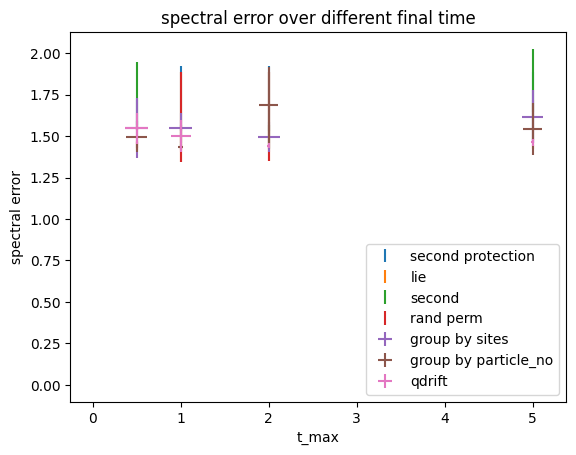

In [ ]:
# plt.scatter([0]+t_list,u2p_m,label='second protection')
# plt.scatter([0]+t_list,ut_m,label='lie')
# plt.scatter([0]+t_list,u2_m,label='second')
# plt.scatter([0]+t_list,urp_m,label='rand perm')
# plt.scatter([0]+t_list,m_noise_mean,label='group by sites')
# plt.scatter([0]+t_list,g_noise_mean,label='group by particle_no')
# plt.scatter([0]+t_list,q_noise_mean,label='qdrift')
plt.errorbar([0]+t_list,u2p_m ,yerr=u2p_s,label='second protection',ls='none')
plt.errorbar([0]+t_list,ut_m ,yerr=ut_s,label='lie',ls='none')
plt.errorbar([0]+t_list,u2_m ,yerr=u2_s,label='second',ls='none')
plt.errorbar([0]+t_list,urp_m ,yerr=urp_s,label='rand perm',ls='none')
plt.errorbar([0]+t_list,m_noise_mean ,yerr=m_noise_std, xerr=m_noise_std_x, label='group by sites',ls='none')
plt.errorbar([0]+t_list,g_noise_mean ,yerr=g_noise_std, xerr=g_noise_std_x, label='group by particle_no',ls='none')
plt.errorbar([0]+t_list,q_noise_mean ,yerr=q_noise_std, xerr=q_noise_std_x, label='qdrift',ls='none')
plt.title('spectral error over different final time')
plt.xlabel('t_max')
plt.ylabel('spectral error') 
plt.legend()

In [ ]:
# u2p = extract_U_at_t(t_list,U2p,secdepth)
# ut = extract_U_at_t(t_list,Ut,ldepth)
# u2 = extract_U_at_t(t_list,U2,secdepth)
# urp = extract_U_at_t(t_list,Urp,rpdepth)
# uexc = extract_U_at_t(t_list,Uexc,np.arange(secdepth[-1]))
# m_mean,m_std = Monte_Carlo_ave(t_list,Um,mdepth,uexc,M=3)
# g_mean,g_std = Monte_Carlo_ave(t_list,Ug,gdepth,uexc,M=3)
# q_mean,q_std = Monte_Carlo_ave(t_list,Uq,qdepth,uexc,M=3)

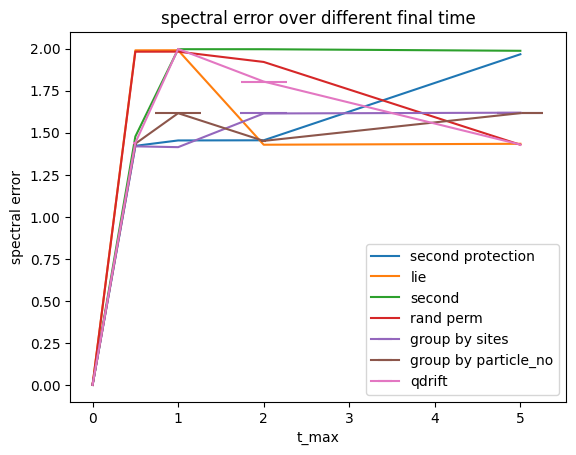

In [ ]:
# plt.plot([0]+t_list,[np.abs(linalg.eig(u - u_exc)[0]).max() for u,u_exc in zip(u2p,uexc)],label='second protection')
# plt.plot([0]+t_list,[np.abs(linalg.eig(u - u_exc)[0]).max() for u,u_exc in zip(ut,uexc)],label='lie')
# plt.plot([0]+t_list,[np.abs(linalg.eig(u - u_exc)[0]).max() for u,u_exc in zip(u2,uexc)],label='second')
# plt.plot([0]+t_list,[np.abs(linalg.eig(u - u_exc)[0]).max() for u,u_exc in zip(urp,uexc)],label='rand perm')
# plt.errorbar([0]+t_list,m_mean ,xerr=m_std, label='group by sites')
# plt.errorbar([0]+t_list,g_mean ,xerr=g_std, label='group by particle_no')
# plt.errorbar([0]+t_list,q_mean ,xerr=q_std, label='qdrift')
# plt.title('spectral error over different final time')
# plt.xlabel('t_max')
# plt.ylabel('spectral error') 
# plt.legend()

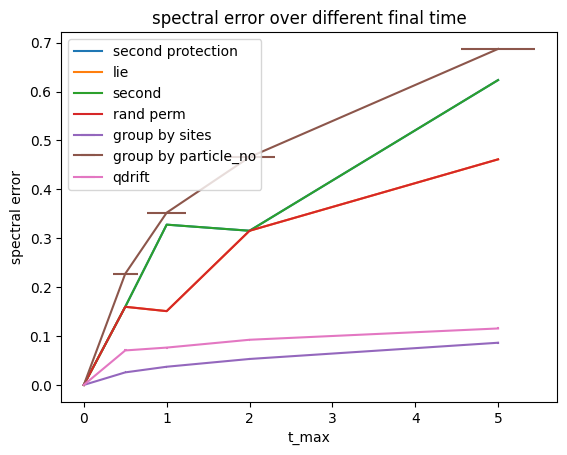

In [ ]:
# plt.plot([0]+t_list,[np.abs(linalg.eig(u - u_exc)[0]).max() for u,u_exc in zip(u2p,uexc)],label='second protection')
# plt.plot([0]+t_list,[np.abs(linalg.eig(u - u_exc)[0]).max() for u,u_exc in zip(ut,uexc)],label='lie')
# plt.plot([0]+t_list,[np.abs(linalg.eig(u - u_exc)[0]).max() for u,u_exc in zip(u2,uexc)],label='second')
# plt.plot([0]+t_list,[np.abs(linalg.eig(u - u_exc)[0]).max() for u,u_exc in zip(urp,uexc)],label='rand perm')
# plt.errorbar([0]+t_list,m_mean ,xerr=m_std, label='group by sites')
# plt.errorbar([0]+t_list,g_mean ,xerr=g_std, label='group by particle_no')
# plt.errorbar([0]+t_list,q_mean ,xerr=q_std, label='qdrift')
# plt.title('spectral error over different final time')
# plt.xlabel('t_max')
# plt.ylabel('spectral error') 
# plt.legend()